In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])


import warnings
warnings.filterwarnings('ignore')


In [2]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

In [3]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

In [4]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

In [5]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

In [7]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']

train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']

train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']

train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']

train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

In [8]:
print("\nTrain Data:")
print(f"Total rows: {len(train)}")
print(f"Number of defaults (y=1): {(train['y']==1).sum()}")
print(f"Default rate: {(train['y']==1).mean():.2%}")

print("\nTest Data:")
print(f"Total rows: {len(test)}")
print(f"Number of defaults (y=1): {(test['y']==1).sum()}")
print(f"Default rate: {(test['y']==1).mean():.2%}")

common_ids = set(train['id']) & set(test['id'])
print(f"\nNumber of overlapping IDs between train and test: {len(common_ids)}")
if len(common_ids) > 0:
    print("\nOverlapping IDs:")
    print(common_ids)



Train Data:
Total rows: 3727
Number of defaults (y=1): 782
Default rate: 20.98%

Test Data:
Total rows: 1059
Number of defaults (y=1): 214
Default rate: 20.21%

Number of overlapping IDs between train and test: 0


In [9]:
data = pd.concat([train, test], axis=0)


# best model found evaluated on given test/train split


Model Coefficients:
                            Feature  Coefficient
0                         feature_1    -5.549201
1                         feature_2    -3.146625
2                         feature_3    -1.989781
3                         feature_4     0.765221
4    feature_1_x_feature_3_spline_0    -0.000024
5    feature_1_x_feature_3_spline_1    -0.000156
6    feature_1_x_feature_3_spline_2    -0.000733
7    feature_1_x_feature_3_spline_3    -0.001180
8    feature_1_x_feature_3_spline_4    -0.001536
9    feature_1_x_feature_3_spline_5    -0.001994
10   feature_1_x_feature_3_spline_6     0.000047
11   feature_1_x_feature_3_spline_7     0.000891
12   feature_1_x_feature_3_spline_8     0.061295
13   feature_1_x_feature_3_spline_9    -0.067174
14  feature_1_x_feature_3_spline_10    -0.846136
15  feature_1_x_feature_3_spline_11    -0.222405
16  feature_1_x_feature_3_spline_12    -0.097994
17  feature_1_x_feature_3_spline_13    -0.183762
18  feature_1_x_feature_3_spline_14     0.000417

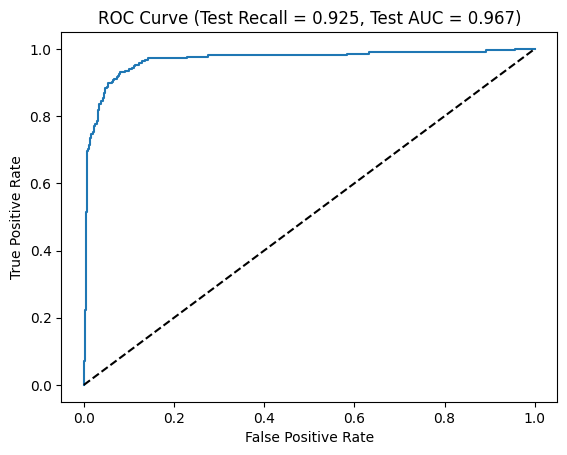

Optimal threshold: 0.314
Final test recall at optimal threshold: 0.925
Final test AUC: 0.967


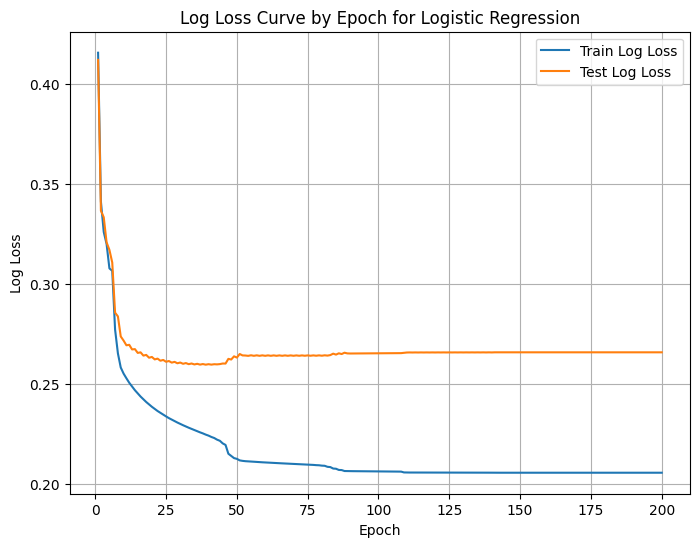

In [10]:
from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_mask_train = interaction_train <= 0
    right_mask_train = ~left_mask_train
    left_mask_test = interaction_test <= 0 
    right_mask_test = ~left_mask_test
    
    X_train_spline = np.zeros((len(data_train), 2 * n_knots + 2 * degree - 2))
    X_test_spline = np.zeros((len(data_test), 2 * n_knots + 2 * degree - 2))
    
    n_features = n_knots + degree - 1
    X_train_spline[left_mask_train, :n_features] = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    X_train_spline[right_mask_train, n_features:] = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    X_test_spline[left_mask_test, :n_features] = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    X_test_spline[right_mask_test, n_features:] = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    return X_train_spline, X_test_spline, spline_left, spline_right

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
splined_interactions = [['feature_1', 'feature_3'], ['feature_3', 'feature_4']]
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4']]

n_knots = 10
degree = 3

X_train = train[features]
X_test = test[features]
y_train = train['y']
y_test = test['y']

X_train_splines = [X_train]
X_test_splines = [X_test]
spline_transformers = {}

for i, interaction in enumerate(splined_interactions):
    X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(train, test, interaction)
    X_train_splines.append(X_train_spline)
    X_test_splines.append(X_test_spline)
    spline_transformers[i] = (spline_left, spline_right)

for interaction in regular_interactions:
    X_train_splines.append((train[interaction[0]] * train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((test[interaction[0]] * test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = LogisticRegression(max_iter=1, warm_start=True, fit_intercept=True)

train_losses = []
test_losses = []
n_epochs = 200

for epoch in range(n_epochs):
    model.fit(X_train_final, y_train)
    train_pred_proba = model.predict_proba(X_train_final)[:, 1]
    test_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    train_loss = log_loss(y_train, train_pred_proba)
    test_loss = log_loss(y_test, test_pred_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

coefficients = pd.DataFrame(
    {'Feature': features + 
     [f"{interaction[0]}_x_{interaction[1]}_spline_{i}" for interaction in splined_interactions for i in range(2 * n_knots + 2 * degree - 2)] +
     [f"{interaction[0]}_x_{interaction[1]}" for interaction in regular_interactions],
     'Coefficient': model.coef_[0]
    })
print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_[0]}")

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

plt.figure(figsize=(8, 6))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_losses, label='Train Log Loss')
plt.plot(epochs, test_losses, label='Test Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve by Epoch for Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

# That best model evaluated on pure random test train splits


Model Coefficients:
                                      Feature   Coefficient
0                                   feature_1 -5.138415e+00
1                                   feature_2 -2.648327e+00
2                                   feature_3 -1.423349e+00
3                                   feature_4  6.429251e-01
4    feature_1_x_feature_3_spline_0 (Splined) -3.648418e-05
5    feature_1_x_feature_3_spline_1 (Splined) -4.035453e-04
6    feature_1_x_feature_3_spline_2 (Splined) -1.240813e-03
7    feature_1_x_feature_3_spline_3 (Splined) -4.657102e-03
8    feature_1_x_feature_3_spline_4 (Splined) -2.533994e-02
9    feature_1_x_feature_3_spline_5 (Splined) -2.737718e-02
10   feature_1_x_feature_3_spline_6 (Splined) -6.192170e-03
11   feature_1_x_feature_3_spline_7 (Splined) -3.249870e-03
12   feature_1_x_feature_3_spline_8 (Splined) -4.149918e-02
13   feature_1_x_feature_3_spline_9 (Splined) -9.715231e-02
14  feature_1_x_feature_3_spline_10 (Splined) -6.154300e-01
15  feature_1_x_fea

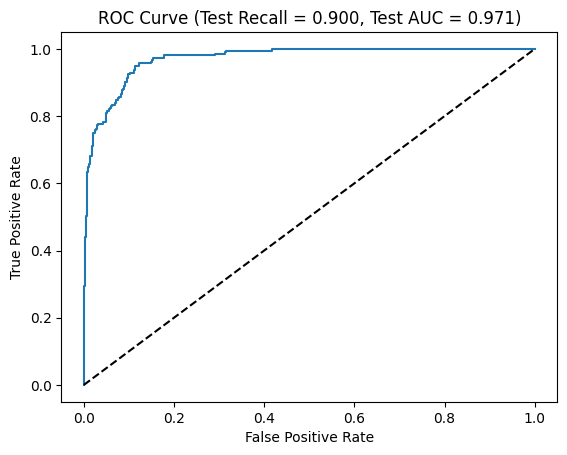

Optimal threshold: 0.294
Final test recall at optimal threshold: 0.900
Final test AUC: 0.971


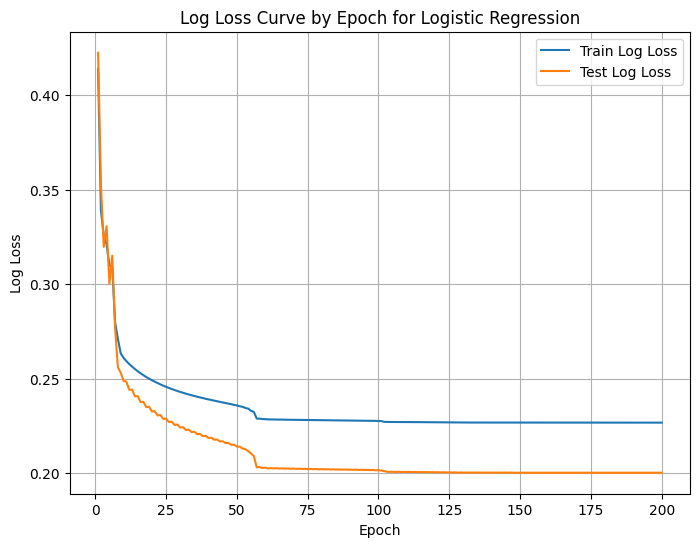

In [11]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.2, random_state=np.random.randint(0, 100000))


from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_mask_train = interaction_train <= 0
    right_mask_train = ~left_mask_train
    left_mask_test = interaction_test <= 0 
    right_mask_test = ~left_mask_test
    
    X_train_spline = np.zeros((len(data_train), 2 * n_knots + 2 * degree - 2))
    X_test_spline = np.zeros((len(data_test), 2 * n_knots + 2 * degree - 2))
    
    n_features = n_knots + degree - 1
    X_train_spline[left_mask_train, :n_features] = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    X_train_spline[right_mask_train, n_features:] = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    X_test_spline[left_mask_test, :n_features] = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    X_test_spline[right_mask_test, n_features:] = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    return X_train_spline, X_test_spline, spline_left, spline_right

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
splined_interactions = [['feature_1', 'feature_3'], ['feature_3', 'feature_4']]
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4']]

n_knots = 10
degree = 3

X_train = data_train[features]
X_test = data_test[features]
y_train = data_train['y']
y_test = data_test['y']

X_train_splines = [X_train]
X_test_splines = [X_test]
spline_transformers = {}

for i, interaction in enumerate(splined_interactions):
    X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(data_train, data_test, interaction)
    X_train_splines.append(X_train_spline)
    X_test_splines.append(X_test_spline)
    spline_transformers[i] = (spline_left, spline_right)

for interaction in regular_interactions:
    X_train_splines.append((data_train[interaction[0]] * data_train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((data_test[interaction[0]] * data_test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = LogisticRegression(max_iter=1, warm_start=True, fit_intercept=True)

train_losses = []
test_losses = []
n_epochs = 200

for epoch in range(n_epochs):
    model.fit(X_train_final, y_train)
    train_pred_proba = model.predict_proba(X_train_final)[:, 1]
    test_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    train_loss = log_loss(y_train, train_pred_proba)
    test_loss = log_loss(y_test, test_pred_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

coefficients = pd.DataFrame(
    {'Feature': features + 
     [f"{interaction[0]}_x_{interaction[1]}_spline_{i} (Splined)" for interaction in splined_interactions for i in range(2 * n_knots + 2 * degree - 2)] +
     [f"{interaction[0]}_x_{interaction[1]} (Linear)" for interaction in regular_interactions],
     'Coefficient': model.coef_[0]
    })
print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_[0]}")

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

plt.figure(figsize=(8, 6))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_losses, label='Train Log Loss')
plt.plot(epochs, test_losses, label='Test Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve by Epoch for Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

# find model that best fits 30 random test train samples 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
import numpy as np
from itertools import combinations

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    left_mask_train = interaction_train <= 0
    right_mask_train = interaction_train > 0
    left_mask_test = interaction_test <= 0
    right_mask_test = interaction_test > 0
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_spline_train = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    right_spline_train = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    
    left_spline_test = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    right_spline_test = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    X_train_spline = np.zeros((len(data_train), left_spline_train.shape[1] + right_spline_train.shape[1]))
    X_test_spline = np.zeros((len(data_test), left_spline_train.shape[1] + right_spline_train.shape[1]))
    
    X_train_spline[left_mask_train, :left_spline_train.shape[1]] = left_spline_train
    X_train_spline[right_mask_train, left_spline_train.shape[1]:] = right_spline_train
    
    X_test_spline[left_mask_test, :left_spline_test.shape[1]] = left_spline_test
    X_test_spline[right_mask_test, left_spline_test.shape[1]:] = right_spline_test
    
    return X_train_spline, X_test_spline, spline_left, spline_right

def get_optimal_threshold_recall(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    fnr = 1 - tpr
    optimal_idx = np.argmin(np.abs(fpr - fnr))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return recall_score(y_true, y_pred)

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interaction_terms = [
    ['feature_1', 'feature_2'],
    ['feature_1', 'feature_3'], 
    ['feature_2', 'feature_3'],
    ['feature_2', 'feature_4'],
    ['feature_3', 'feature_4']
]

all_results = []
best_model = None
best_recall = -1

print("Evaluating all possible combinations:")
for r in range(len(interaction_terms) + 1):
    for spline_terms in combinations(range(len(interaction_terms)), r):
        recalls = []
        aucs = []
        
        spline_desc = "None" if len(spline_terms) == 0 else [f"{interaction_terms[i][0]}_x_{interaction_terms[i][1]}" for i in spline_terms]
        
        for _ in range(200):
            data_train, data_test = train_test_split(data, test_size=0.2, random_state=np.random.randint(0, 100000))
            
            X_train = data_train[features]
            X_test = data_test[features]
            y_train = data_train['y']
            y_test = data_test['y']
            
            X_train_splines = []
            X_test_splines = []
            
            for i, interaction_term in enumerate(interaction_terms):
                if i in spline_terms:
                    X_train_spline, X_test_spline, _, _ = create_split_splines(data_train, data_test, interaction_term)
                    X_train_splines.append(X_train_spline)
                    X_test_splines.append(X_test_spline)
                else:
                    interaction_name = f'{interaction_term[0]}_x_{interaction_term[1]}'
                    X_train_splines.append(data_train[interaction_name].values.reshape(-1, 1))
                    X_test_splines.append(data_test[interaction_name].values.reshape(-1, 1))

            X_train_final = np.hstack([X_train] + X_train_splines)
            X_test_final = np.hstack([X_test] + X_test_splines)

            model = LogisticRegression()
            model.fit(X_train_final, y_train)
            test_pred_proba = model.predict_proba(X_test_final)[:, 1]
            current_recall = get_optimal_threshold_recall(y_test, test_pred_proba)
            recalls.append(current_recall)
            aucs.append(roc_auc_score(y_test, test_pred_proba))
        
        avg_recall = np.mean(recalls)
        avg_auc = np.mean(aucs)
        std_recall = np.std(recalls)
        std_auc = np.std(aucs)
        all_results.append((avg_recall, std_recall, avg_auc, std_auc, spline_desc))

print("\nAll combinations sorted by average recall (descending):")
all_results = sorted(all_results, key=lambda x: x[0], reverse=True)
for avg_recall, std_recall, avg_auc, std_auc, spline_desc in all_results:
    print(f"Avg Recall: {avg_recall:.3f} (±{std_recall:.3f}), Avg AUC: {avg_auc:.3f} (±{std_auc:.3f}) - Splined terms: {spline_desc}")


Evaluating all possible combinations:



All combinations sorted by average recall (descending):
Avg Recall: 0.909 (±0.010), Avg AUC: 0.964 (±0.007) - Splined terms: ['feature_3_x_feature_4']
Avg Recall: 0.908 (±0.010), Avg AUC: 0.964 (±0.007) - Splined terms: ['feature_1_x_feature_3', 'feature_3_x_feature_4']
Avg Recall: 0.905 (±0.011), Avg AUC: 0.962 (±0.007) - Splined terms: ['feature_2_x_feature_3', 'feature_3_x_feature_4']
Avg Recall: 0.904 (±0.010), Avg AUC: 0.963 (±0.007) - Splined terms: ['feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_3_x_feature_4']
Avg Recall: 0.903 (±0.011), Avg AUC: 0.959 (±0.007) - Splined terms: ['feature_2_x_feature_4', 'feature_3_x_feature_4']
Avg Recall: 0.901 (±0.012), Avg AUC: 0.959 (±0.008) - Splined terms: ['feature_1_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']
Avg Recall: 0.901 (±0.010), Avg AUC: 0.963 (±0.007) - Splined terms: ['feature_1_x_feature_3']
Avg Recall: 0.900 (±0.011), Avg AUC: 0.958 (±0.007) - Splined terms: ['feature_2_x_feature_3', 'feature

# That best model evaluated on random train test splits by ID groupings 

False
False
False
False
False


,feature_1,feature_2,feature_3,feature_4,id,date,y,feature_1_x_feature_2,feature_1_x_feature_3,feature_1_x_feature_4,feature_2_x_feature_3,feature_2_x_feature_4,feature_3_x_feature_4
0,0.053493,0.057374,-0.073933,-0.420557,50501,2000,0,0.003069,-0.003955,-0.022497,-0.004242,-0.024129,0.031093
1,-0.315388,0.029476,-0.140006,0.997907,50501,2001,1,-0.009296,0.044156,-0.314728,-0.004127,0.029414,-0.139713
2,-0.225211,-1.153009,-0.069998,1.362336,50501,2002,0,0.259670,0.015764,-0.306812,0.080708,-1.570786,-0.095361
3,-0.209159,-0.067340,-0.153642,0.145434,50501,2003,0,0.014085,0.032135,-0.030419,0.010346,-0.009793,-0.022345
4,-0.174308,-1.690908,-0.005939,1.902415,50501,2004,0,0.294739,0.001035,-0.331607,0.010042,-3.216808,-0.011298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,4.826724,1.497930,0.229161,-0.881348,50901,2000,0,7.230093,1.106098,-4.254024,0.343267,-1.320198,-0.201971
1055,-0.221668,-0.406563,-0.180591,-0.146282,50901,2001,0,0.090122,0.040031,0.032426,0.073421,0.059473,0.026417
1056,0.047032,-0.576580,0.062642,1.459979,50901,2002,0,-0.027118,0.002946,0.068665,-0.036118,-0.841795,0.091456
1057,-0.099301,0.005305,-0.152984,-0.533623,50901,2003,0,-0.000527,0.015191,0.052989,-0.000812,-0.002831,0.081636


,feature_1,feature_2,feature_3,feature_4,id,date,y,feature_1_x_feature_2,feature_1_x_feature_3,feature_1_x_feature_4,feature_2_x_feature_3,feature_2_x_feature_4,feature_3_x_feature_4
37,-0.418051,0.407682,-0.172075,1.213307,50504,2000,1,-0.170432,0.071936,-0.507224,-0.070152,0.494644,-0.208779
39,4.625804,1.494143,0.217613,-0.785759,50504,2002,0,6.911614,1.006636,-3.634767,0.325145,-1.174037,-0.170992
40,-0.038314,0.057616,-0.139998,-0.739470,50504,2003,0,-0.002208,0.005364,0.028332,-0.008066,-0.042605,0.103524
41,-0.017535,0.284150,-0.029873,0.625158,50504,2004,0,-0.004983,0.000524,-0.010962,-0.008488,0.177638,-0.018675
42,0.538687,1.264857,0.150756,-0.402293,50504,2005,0,0.681362,0.081210,-0.216710,0.190685,-0.508843,-0.060648
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,-4.643407,-1.712853,-0.564267,0.203661,50897,2007,0,7.953473,2.620121,-0.945681,0.966506,-0.348841,-0.114919
1010,0.076024,-0.168243,0.045279,1.049225,50897,2008,0,-0.012791,0.003442,0.079766,-0.007618,-0.176525,0.047508
1011,0.320272,0.697918,-0.001227,-1.099394,50897,2009,0,0.223524,-0.000393,-0.352105,-0.000856,-0.767287,0.001349
1012,5.903632,1.748281,10.419931,-1.559880,50897,2010,0,10.321209,61.515439,-9.208957,18.216968,-2.727108,-16.253840



Model Coefficients:
                                      Feature   Coefficient
0                                   feature_1 -5.278501e+00
1                                   feature_2 -2.688816e+00
2                                   feature_3 -1.491905e+00
3                                   feature_4  6.708895e-01
4    feature_1_x_feature_3_spline_0 (Splined) -2.888241e-05
5    feature_1_x_feature_3_spline_1 (Splined) -4.692424e-04
6    feature_1_x_feature_3_spline_2 (Splined) -1.055538e-02
7    feature_1_x_feature_3_spline_3 (Splined) -1.324175e-02
8    feature_1_x_feature_3_spline_4 (Splined) -6.596716e-03
9    feature_1_x_feature_3_spline_5 (Splined) -2.432104e-02
10   feature_1_x_feature_3_spline_6 (Splined) -7.250130e-03
11   feature_1_x_feature_3_spline_7 (Splined) -4.322896e-03
12   feature_1_x_feature_3_spline_8 (Splined) -7.206800e-02
13   feature_1_x_feature_3_spline_9 (Splined) -1.212737e-01
14  feature_1_x_feature_3_spline_10 (Splined) -6.288560e-01
15  feature_1_x_fea

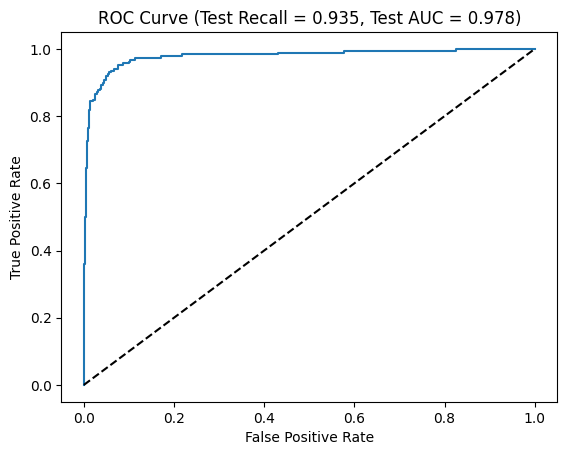

Optimal threshold: 0.313
Final test recall at optimal threshold: 0.935
Final test AUC: 0.978


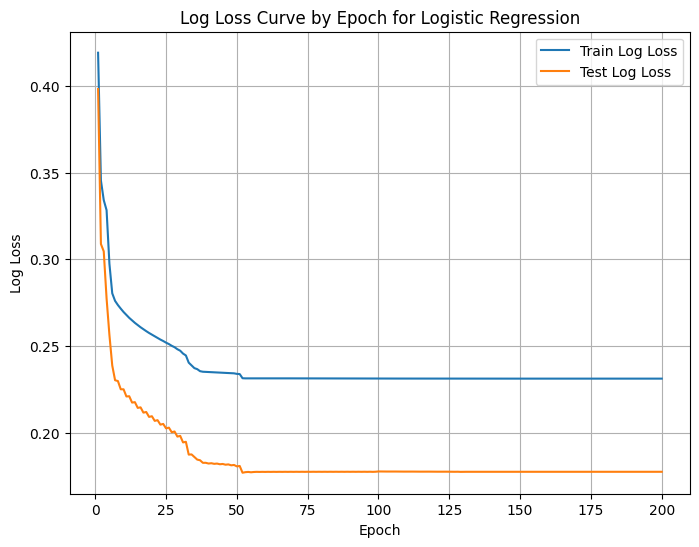

In [13]:
unique_ids = data['id'].unique()
n_splits = 5
recalls = []
aucs = []

for _ in range(n_splits):
    test_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * 0.2), replace=False)
    train_ids = np.array([id_ for id_ in unique_ids if id_ not in test_ids])
    data_train = data[data['id'].isin(train_ids)]
    data_test = data[data['id'].isin(test_ids)]
    print(any(np.isin(data_train['id'].unique(), data_test['id'].unique())))



display(data_train)
display(data_test)

from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_mask_train = interaction_train <= 0
    right_mask_train = ~left_mask_train
    left_mask_test = interaction_test <= 0 
    right_mask_test = ~left_mask_test
    
    X_train_spline = np.zeros((len(data_train), 2 * n_knots + 2 * degree - 2))
    X_test_spline = np.zeros((len(data_test), 2 * n_knots + 2 * degree - 2))
    
    n_features = n_knots + degree - 1
    X_train_spline[left_mask_train, :n_features] = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    X_train_spline[right_mask_train, n_features:] = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    X_test_spline[left_mask_test, :n_features] = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    X_test_spline[right_mask_test, n_features:] = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    return X_train_spline, X_test_spline, spline_left, spline_right

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
splined_interactions = [['feature_1', 'feature_3'], ['feature_3', 'feature_4']]
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4']]

n_knots = 10
degree = 3

X_train = data_train[features]
X_test = data_test[features]
y_train = data_train['y']
y_test = data_test['y']

X_train_splines = [X_train]
X_test_splines = [X_test]
spline_transformers = {}

for i, interaction in enumerate(splined_interactions):
    X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(data_train, data_test, interaction)
    X_train_splines.append(X_train_spline)
    X_test_splines.append(X_test_spline)
    spline_transformers[i] = (spline_left, spline_right)

for interaction in regular_interactions:
    X_train_splines.append((data_train[interaction[0]] * data_train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((data_test[interaction[0]] * data_test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = LogisticRegression(max_iter=1, warm_start=True, fit_intercept=True)

train_losses = []
test_losses = []
n_epochs = 200

for epoch in range(n_epochs):
    model.fit(X_train_final, y_train)
    train_pred_proba = model.predict_proba(X_train_final)[:, 1]
    test_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    train_loss = log_loss(y_train, train_pred_proba)
    test_loss = log_loss(y_test, test_pred_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

coefficients = pd.DataFrame(
    {'Feature': features + 
     [f"{interaction[0]}_x_{interaction[1]}_spline_{i} (Splined)" for interaction in splined_interactions for i in range(2 * n_knots + 2 * degree - 2)] +
     [f"{interaction[0]}_x_{interaction[1]} (Linear)" for interaction in regular_interactions],
     'Coefficient': model.coef_[0]
    })
print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_[0]}")

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

plt.figure(figsize=(8, 6))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_losses, label='Train Log Loss')
plt.plot(epochs, test_losses, label='Test Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve by Epoch for Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
import numpy as np
from itertools import combinations

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    left_mask_train = interaction_train <= 0
    right_mask_train = interaction_train > 0
    left_mask_test = interaction_test <= 0
    right_mask_test = interaction_test > 0
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_spline_train = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    right_spline_train = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    
    left_spline_test = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    right_spline_test = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    X_train_spline = np.zeros((len(data_train), left_spline_train.shape[1] + right_spline_train.shape[1]))
    X_test_spline = np.zeros((len(data_test), left_spline_train.shape[1] + right_spline_train.shape[1]))
    
    X_train_spline[left_mask_train, :left_spline_train.shape[1]] = left_spline_train
    X_train_spline[right_mask_train, left_spline_train.shape[1]:] = right_spline_train
    
    X_test_spline[left_mask_test, :left_spline_test.shape[1]] = left_spline_test
    X_test_spline[right_mask_test, left_spline_test.shape[1]:] = right_spline_test
    
    return X_train_spline, X_test_spline, spline_left, spline_right

def get_optimal_threshold_recall(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    fnr = 1 - tpr
    optimal_idx = np.argmin(np.abs(fpr - fnr))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return recall_score(y_true, y_pred)

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interaction_terms = [
    ['feature_1', 'feature_2'],
    ['feature_1', 'feature_3'], 
    ['feature_2', 'feature_3'],
    ['feature_2', 'feature_4'],
    ['feature_3', 'feature_4']
]

all_results = []
best_model = None
best_recall = -1

print("Evaluating all possible combinations:")
for r in range(len(interaction_terms) + 1):
    for spline_terms in combinations(range(len(interaction_terms)), r):
        recalls = []
        aucs = []
        
        spline_desc = "None" if len(spline_terms) == 0 else [f"{interaction_terms[i][0]}_x_{interaction_terms[i][1]}" for i in spline_terms]
        
        for _ in range(200):
            unique_ids = data['id'].unique()
            test_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * 0.2), replace=False)
            train_ids = np.array([id_ for id_ in unique_ids if id_ not in test_ids])
            data_train = data[data['id'].isin(train_ids)]
            data_test = data[data['id'].isin(test_ids)]
            
            X_train = data_train[features]
            X_test = data_test[features]
            y_train = data_train['y']
            y_test = data_test['y']
            
            X_train_splines = []
            X_test_splines = []
            
            for i, interaction_term in enumerate(interaction_terms):
                if i in spline_terms:
                    X_train_spline, X_test_spline, _, _ = create_split_splines(data_train, data_test, interaction_term)
                    X_train_splines.append(X_train_spline)
                    X_test_splines.append(X_test_spline)
                else:
                    interaction_name = f'{interaction_term[0]}_x_{interaction_term[1]}'
                    X_train_splines.append(data_train[interaction_name].values.reshape(-1, 1))
                    X_test_splines.append(data_test[interaction_name].values.reshape(-1, 1))

            X_train_final = np.hstack([X_train] + X_train_splines)
            X_test_final = np.hstack([X_test] + X_test_splines)

            model = LogisticRegression()
            model.fit(X_train_final, y_train)
            test_pred_proba = model.predict_proba(X_test_final)[:, 1]
            current_recall = get_optimal_threshold_recall(y_test, test_pred_proba)
            recalls.append(current_recall)
            aucs.append(roc_auc_score(y_test, test_pred_proba))
        
        avg_recall = np.mean(recalls)
        avg_auc = np.mean(aucs)
        std_recall = np.std(recalls)
        std_auc = np.std(aucs)
        all_results.append((avg_recall, std_recall, avg_auc, std_auc, spline_desc))

print("\nAll combinations sorted by average recall (descending):")
all_results = sorted(all_results, key=lambda x: x[0], reverse=True)
for avg_recall, std_recall, avg_auc, std_auc, spline_desc in all_results:
    print(f"Avg Recall: {avg_recall:.3f} (±{std_recall:.3f}), Avg AUC: {avg_auc:.3f} (±{std_auc:.3f}) - Splined terms: {spline_desc}")


Evaluating all possible combinations:


In [ ]:

            test_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * 0.2), replace=False)
            train_ids = np.array([id_ for id_ in unique_ids if id_ not in test_ids])
            data_train = data[data['id'].isin(train_ids)]
            data_test = data[data['id'].isin(test_ids)]

